In [ ]:
!pip install datasets

In [ ]:
import torch
from torch import nn
from torch.optim import Adam
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image
import io
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

In [ ]:
from datasets import load_dataset

dataset = load_dataset("Jeneral/fer2013")

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['img_bytes', 'labels'],
        num_rows: 35887
    })
})


In [ ]:
labels = [x["labels"] for x in dataset["train"]]
images = [x["img_bytes"] for x in dataset["train"]]

Angry


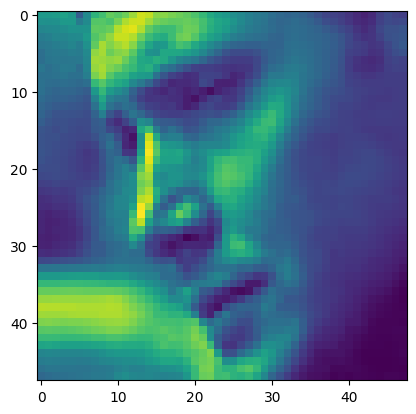

In [ ]:
def label_to_emotion(label):
    emotions = {0: 'Angry',\
              1: 'Disgust', \
              2: 'Fear', \
              3:'Happy',
              4:'Sad', \
              5: 'Surprise', \
              6: 'Neutral'}
    return emotions[label]

def display_image(img_bytes):
    # Load the image from bytes
    img = Image.open(io.BytesIO(img_bytes))

    # Display the image
    plt.imshow(img)
    plt.show()


def convert_image_to_tensor(img_bytes):
    # Define the transformation
    img = Image.open(io.BytesIO(img_bytes))
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    # add an extra dimension (for the batch)
    img_tensor = transform(img).unsqueeze(0)

    return img_tensor

print(label_to_emotion(labels[2]))
display_image(images[2])

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])

# Convert images to tensor
image_tensors = torch.stack([convert_image_to_tensor(image) for image in images])
label_tensors = torch.tensor(labels)

# My own test set for the end..
test_image_tensors = image_tensors[:100]
test_label_tensors = label_tensors[:100]

X_train, X_test, y_train, y_test = train_test_split(image_tensors[100:], label_tensors[100:], test_size=0.2, random_state=42)

# Transform lists into TensorDataset
train_data = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
test_data = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

<ipython-input-6-fc1567ee8a6e>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
<ipython-input-6-fc1567ee8a6e>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_data = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))


In [ ]:
image_tensors[:100].shape

torch.Size([100, 1, 1, 48, 48])

In [ ]:
X_train[0].shape

torch.Size([1, 1, 48, 48])

In [ ]:
num_features = 64
num_labels = 7
batch_size = 64
width, height = 48, 48

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        layers = [
            nn.Conv2d(1, num_features, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(num_features, num_features, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.5)
        ]

        for i in range(3):
            layers.extend([
                nn.Conv2d(num_features * (2 ** i), num_features * (2 ** (i+1)), kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(num_features * (2 ** (i+1)), num_features * (2 ** (i+1)), kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(num_features * (2 ** (i+1))),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Dropout(0.5)
            ])

        self.features = nn.Sequential(*layers)

        self.classifier = nn.Sequential(
            nn.Linear(4608, 256),
            nn.Linear(2*2*num_features, 2*2*2*num_features),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(2*2*2*num_features, 2*2*num_features),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(2*2*num_features, 2*num_features),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(2*num_features, num_labels)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) #flattens our tensor into 4608
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)

model = Net()
pred = model(image_tensors[0])
print(pred)


tensor([[-2.0500, -1.8436, -1.9497, -1.8418, -1.8116, -2.0881, -2.0806]],
       grad_fn=<LogSoftmaxBackward0>)


In [ ]:
image_tensors[0].squeeze().shape

torch.Size([48, 48])

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Check if CUDA is available and set PyTorch to use GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()

model = model.to(device)
optimizer = Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-7)

for epoch in range(100):

    model.train()
    running_loss = 0.0
    test_correct = 0
    test_total = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.squeeze(1) #[64, 1, 48, 48]

        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

    test_accuracy = test_correct / test_total * 100

    model.eval()  # Set the network to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            inputs, labels = data

            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.squeeze(1) #[64, 1, 48, 48]
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    validation_accuracy = correct / total * 100

    print('Epoch: %d, Test Accuracy: %.2f,Test Loss: %.2f, Validation Accuracy: %.2f, Validation Loss: %.3f' %
          (epoch + 1, test_accuracy, running_loss/len(train_loader), validation_accuracy, val_loss / len(test_loader),))

print('Finished Training')


Epoch: 1, Test Accuracy: 25.26,Test Loss: 1.81, Validation Accuracy: 30.33, Validation Loss: 1.719
Epoch: 2, Test Accuracy: 33.21,Test Loss: 1.67, Validation Accuracy: 34.52, Validation Loss: 1.623
Epoch: 3, Test Accuracy: 38.63,Test Loss: 1.56, Validation Accuracy: 42.60, Validation Loss: 1.474
Epoch: 4, Test Accuracy: 41.14,Test Loss: 1.51, Validation Accuracy: 44.82, Validation Loss: 1.429
Epoch: 5, Test Accuracy: 42.75,Test Loss: 1.46, Validation Accuracy: 45.46, Validation Loss: 1.396
Epoch: 6, Test Accuracy: 44.34,Test Loss: 1.43, Validation Accuracy: 46.79, Validation Loss: 1.359
Epoch: 7, Test Accuracy: 46.26,Test Loss: 1.39, Validation Accuracy: 49.80, Validation Loss: 1.310
Epoch: 8, Test Accuracy: 48.02,Test Loss: 1.36, Validation Accuracy: 51.69, Validation Loss: 1.261
Epoch: 9, Test Accuracy: 49.08,Test Loss: 1.33, Validation Accuracy: 53.16, Validation Loss: 1.244
Epoch: 10, Test Accuracy: 50.60,Test Loss: 1.30, Validation Accuracy: 53.17, Validation Loss: 1.236
Epoch: 11

Predicted: Angry
Actual: Angry


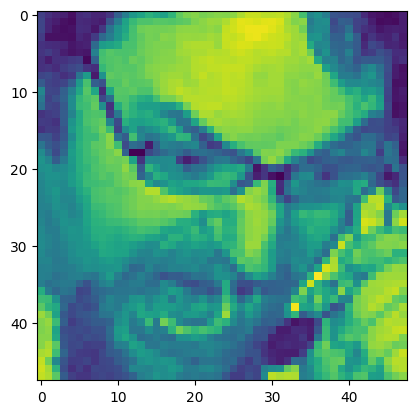

Predicted: Fear
Actual: Angry


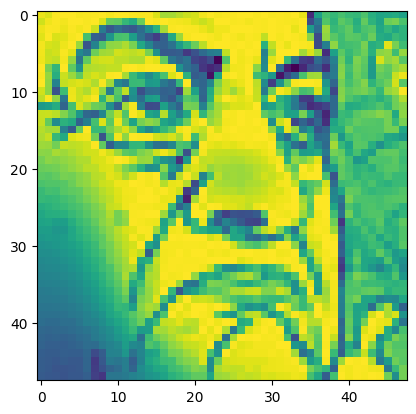

Predicted: Angry
Actual: Angry


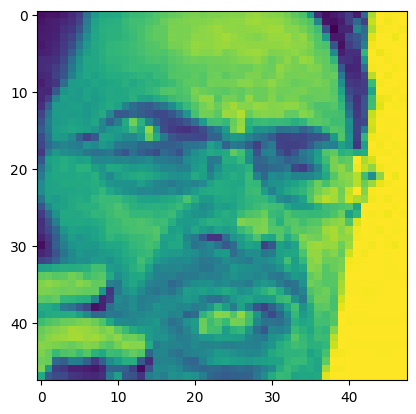

Predicted: Angry
Actual: Angry


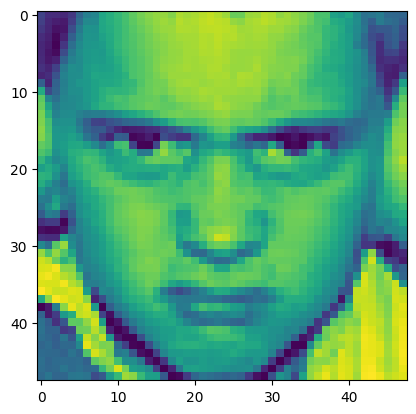

In [ ]:
from PIL import Image
from torchvision import transforms

def predict_image(model, num):
    to_pil = transforms.ToPILImage()
    img = to_pil(test_image_tensors[num].squeeze(0))  # Remove the batch dimension and convert to PIL Image

    transform = transforms.Compose([
        # transforms.Resize((48, 48)),
        transforms.ToTensor(),
    ])

    # Apply the transformations and add an extra dimension for the batch
    image_tensor_transformed = transform(img).unsqueeze(0)

    # Move the tensor to the same device as your model
    image_tensor_transformed = image_tensor_transformed.to(device)

    # Make sure your model is in eval mode
    model.eval()

    # Make the prediction
    with torch.no_grad():
        output = model(image_tensor_transformed)

    # Get the predicted class
    _, predicted = torch.max(output, 1)

    print("Predicted:", label_to_emotion(predicted.item()))
    print("Actual:", label_to_emotion(test_label_tensors[num].item()))

    # Display the image
    plt.imshow(img)
    plt.show()

    return predicted.item()


predicted_class = predict_image(model, 0)

predicted_class = predict_image(model, 5)

predicted_class = predict_image(model,23)

predicted_class = predict_image(model,79)

